In [1]:
import pandas as pd
import altair as alt
import sklearn as sk
import numpy as np

In [2]:
gps = pd.read_csv("gps.csv")
games = pd.read_csv("games.csv", parse_dates=["Date"])
rpe = pd.read_csv("rpe.csv")
wellness = pd.read_csv("wellness_standardized.csv",parse_dates=["Date"])

In [3]:
gps1 = gps.groupby(['GameID','PlayerID','Time'])["Speed"].aggregate("mean")
gps1 = gps1.to_frame().rename(columns={"Speed":"AvgSpeed"})
gps2 = gps1.groupby(["GameID","PlayerID"])["AvgSpeed"].sum()
gps2 = gps2.to_frame().rename(columns={"AvgSpeed":"Distance"})
gps3 = gps1.groupby(["GameID","PlayerID"])["AvgSpeed"].aggregate("mean")
gps3 = gps3.to_frame()
df1 = gps2.merge(gps3, on=["GameID","PlayerID"])
df1 = df1.reset_index()

In [4]:
games2 = games[["GameID","Date"]]
df2 = df1.merge(games2, how="outer", on="GameID")
df2 = df2.drop("GameID",axis=1)
df2.head()

,PlayerID,Distance,AvgSpeed,Date
0,2,848.761698,0.790281,2017-11-30
1,3,1381.058219,1.285902,2017-11-30
2,4,808.236472,0.752548,2017-11-30
3,6,693.076311,0.645322,2017-11-30
4,7,1480.425598,1.378422,2017-11-30


In [5]:
df3 = df2.groupby(["PlayerID","Date"]).aggregate({"Distance":"mean","AvgSpeed":"mean"})
df3.reset_index(inplace=True)

In [6]:
df3.to_csv("distspeed.csv")

In [7]:
daily = pd.read_csv("daily.csv").drop("Unnamed: 0", axis=1)

In [8]:
def convert_dec(x):
    return float(str(x).replace("%","")) / 100

In [9]:
daily["TrainingReadiness"] = daily["TrainingReadiness"].apply(convert_dec)

In [10]:
daily.head()

,index,PlayerID,AvgImpulseSpike,Date,DaysSinceLast,DaysTillNext,DistanceLastGame,AvgSpeedLastGame,Fatigue,Soreness,...,SkillsSession,SpeedSession,StrengthSession,CombatSession,TrainingDay,RestDay,interactAvgSessionDurationTraining,interactAvgRPETraining,DistanceLastGame*DaysSinceLast,AvgImpulseSpike*DaysSinceLast
0,0,2,84.666667,2017-11-30,0,0.0,1319.919062,1.203891,4,4,...,0,0,0,0,1,0,28.000000,-0.406781,0.0,0.0
1,1,3,60.666667,2017-11-30,0,0.0,1333.256556,1.223013,5,4,...,0,0,0,0,0,1,0.000000,0.000000,0.0,0.0
2,2,4,94.666667,2017-11-30,0,0.0,1249.011314,1.138543,3,6,...,0,0,0,0,1,0,34.333333,0.823737,0.0,0.0
3,3,6,56.666667,2017-11-30,0,0.0,857.369033,0.783176,4,4,...,0,0,0,0,1,0,29.333333,1.601873,0.0,0.0
4,4,7,71.000000,2017-11-30,0,0.0,1213.729850,1.115228,5,4,...,0,0,0,0,1,0,35.500000,1.614225,0.0,0.0


In [11]:
daily = pd.read_csv("daily.csv", parse_dates=["Date"]).drop(["Unnamed: 0"], axis=1)

### Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split

In [13]:
lreg = LinearRegression()

In [14]:
daily.columns

Index(['index', 'PlayerID', 'AvgImpulseSpike', 'Date', 'DaysSinceLast',
       'DaysTillNext', 'DistanceLastGame', 'AvgSpeedLastGame', 'Fatigue',
       'Soreness', 'Desire', 'Irritability', 'BedTime', 'WakeTime',
       'SleepHours', 'SleepQuality', 'MonitoringScore', 'Pain', 'Illness',
       'Menstruation', 'Nutrition', 'NutritionAdjustment', 'USGMeasurement',
       'USG', 'TrainingReadiness', 'Fatigue_standard', 'Soreness_standard',
       'Desire_standard', 'Irritability_standard', 'SleepHours_standard',
       'SleepQuality_standard', 'MonitoringScore_standard', 'USG_standard',
       'LastWins', 'LastLosses', 'LastWLDiff', 'LastWon', 'avgRPE',
       'avgSessionDuration', 'TotalTrainingSessions', 'ConditioningSession',
       'GameSession', 'Mobility/RecoverySession', 'SkillsSession',
       'SpeedSession', 'StrengthSession', 'CombatSession', 'TrainingDay',
       'RestDay', 'interactAvgSessionDurationTraining',
       'interactAvgRPETraining', 'DistanceLastGame*DaysSinceLast',

In [15]:
daily['distanceInteract'] = daily["DistanceLastGame"] * daily["DaysSinceLast"]
daily['speedInteract'] = daily["AvgSpeedLastGame"] * daily["DaysSinceLast"]

In [16]:
X = daily[['DaysSinceLast', 'DaysTillNext', 'PlayerID',
       'DistanceLastGame', 'AvgSpeedLastGame', 'Soreness_standard', 'Desire_standard',
       'Irritability_standard', 'SleepHours_standard', 'SleepQuality_standard',
       'Pain', 'Illness','Menstruation', 'Nutrition',
       'NutritionAdjustment', 'TrainingReadiness','LastWins', 'LastLosses','LastWon',
          'avgRPE',
       'avgSessionDuration','ConditioningSession',
       'GameSession', 'Mobility/RecoverySession', 'SkillsSession',
       'SpeedSession', 'StrengthSession', 'CombatSession', 'TrainingDay',
       'RestDay', 'interactAvgSessionDurationTraining',
       'interactAvgRPETraining', 'distanceInteract','speedInteract']]
X = pd.get_dummies(X, drop_first=True)
y = daily['Fatigue_standard']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=1)

In [18]:
lreg.fit(X_train,y_train)
y_pred = lreg.predict(X_test)
lreg.score(X_test, y_test)

0.3420228668972588

In [19]:
from sklearn.model_selection import GridSearchCV
param_grid = {'fit_intercept':[True,False]}
grid = GridSearchCV(LinearRegression(), param_grid, cv=5)
grid.fit(X_test, y_test);
model = grid.best_estimator_
model

/Users/markelle/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

### Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
rfc = RandomForestRegressor(n_estimators=100, criterion="mae")

In [22]:
rfc.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [23]:
y_pred = rfc.predict(X_test)
rfc.score(X_test, y_test)

0.2905359141175071

In [24]:
from sklearn.model_selection import cross_val_score
trainscore = np.mean(cross_val_score(rfc, X_train, y_train, cv=5))
testscore = np.mean(cross_val_score(rfc, X_test, y_test, cv=5))
print("Train Score:", trainscore)
print("Test Score:", testscore)

Train Score: 0.3693933598096592
Test Score: 0.2764146253402494


## SVC 

In [25]:
def to_cat(fatigue_standard):
    if fatigue_standard <= -0.6:
        return 'Low'
    elif fatigue_standard <= 0.6:
        return 'Mid'
    else:
        return 'High'

y = daily['Fatigue_standard']

y_cat = pd.Series([to_cat(fatigue) for fatigue in y])

In [26]:
from sklearn.svm import SVC

In [27]:
svc = SVC(gamma="scale",kernel="poly")
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = .25, random_state=1)

In [28]:
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
svc.score(X_test, y_test)

0.421455938697318

## EDA

In [29]:
daily = pd.read_csv("daily.csv", parse_dates=["Date"]).drop(["Unnamed: 0"], axis=1)

In [30]:
daily["GameDay"] = daily["DaysSinceLast"]==0

In [31]:
daily.reset_index(inplace=True)

In [32]:
daily.tail()

,level_0,index,PlayerID,AvgImpulseSpike,Date,DaysSinceLast,DaysTillNext,DistanceLastGame,AvgSpeedLastGame,Fatigue,...,SpeedSession,StrengthSession,CombatSession,TrainingDay,RestDay,interactAvgSessionDurationTraining,interactAvgRPETraining,DistanceLastGame*DaysSinceLast,AvgImpulseSpike*DaysSinceLast,GameDay
2083,2083,775,15,73.0,2018-07-10,30,9.0,812.922317,0.844156,4,...,0,0,0,1,0,12.000000,1.050612,24387.669510,2190.0,False
2084,2084,775,15,73.0,2018-07-11,31,8.0,812.922317,0.844156,3,...,0,0,0,0,1,0.000000,0.000000,25200.591827,2263.0,False
2085,2085,775,15,73.0,2018-07-17,37,2.0,812.922317,0.844156,4,...,0,0,0,1,0,60.000000,0.046027,30078.125729,2701.0,False
2086,2086,793,11,87.0,2018-07-20,0,0.0,1675.665345,1.571964,4,...,0,0,0,1,0,29.000000,0.435365,0.000000,0.0,True
2087,2087,794,13,54.0,2018-07-20,0,0.0,796.364711,0.745655,4,...,0,0,0,1,0,20.333333,0.121755,0.000000,0.0,True


player 10 - tried avg rpe, avg impulse spike, average speed, sleep

In [33]:
dailyPlayer = daily[daily["PlayerID"] == 1]

In [34]:
dailyPlayer["StdSleep"] = dailyPlayer["SleepHours_standard"] -3
dailyPlayer["stdSpeed"] = dailyPlayer["AvgSpeedLastGame"]*2

/Users/markelle/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/markelle/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
gameDays = dailyPlayer[dailyPlayer["DaysSinceLast"]==0]

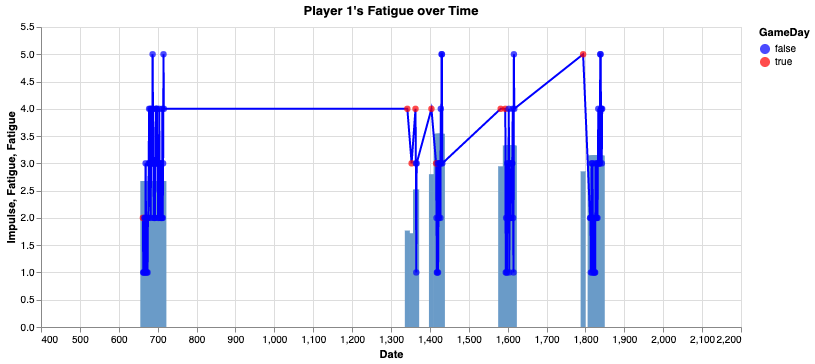

In [44]:
fatigue = alt.Chart(dailyPlayer).mark_circle(color='blue', size=40).encode(
    alt.X('level_0:Q',axis=alt.Axis(title='Date'),scale=alt.Scale(domain=[500,2000])),
    alt.Y('Fatigue:Q',axis=alt.Axis(title="Fatigue")),
    alt.Color('GameDay:N',scale=alt.Scale(domain=["false","true"],range=["blue","red"]))
).properties(
    title="Player 1's Fatigue over Time",
    height=300,
    width=700
)

chart_two = alt.Chart(gameDays).mark_rule(color="red").encode(
    alt.X('level_0:Q',scale=alt.Scale(domain=[500,2000]))
)


fatigue_line = alt.Chart(dailyPlayer).mark_line(color='blue').encode(
    alt.X('level_0:Q',axis=alt.Axis(title='Date'),scale=alt.Scale(domain=[500,2000])),
    alt.Y('Fatigue:Q',axis=alt.Axis(title="Fatigue"), scale=alt.Scale(domain=[0,5.1])),
).properties(
    title="Player 1's Fatigue over Time",
    height=300,
    width=700
)

impulse = alt.Chart(dailyPlayer).mark_bar(color="rgb(106,155,200)").encode(
    alt.X('level_0:Q',axis=alt.Axis(title='Date'),scale=alt.Scale(domain=[500,2000])),
    alt.Y('stdSpeed:Q',axis=alt.Axis(title="Impulse")),
)

#(impulse + fatigue_line+ fatigue).configure_axis(grid=False)
impulse + fatigue_line+ fatigue

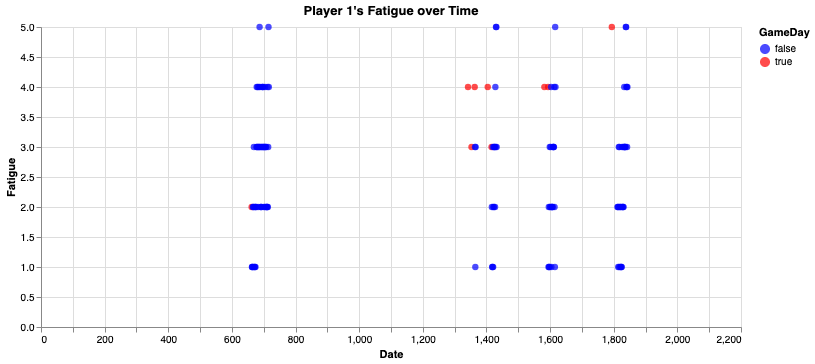

In [41]:
fatigue = alt.Chart(dailyPlayer).mark_circle(color='black', size=40).encode(
    alt.X('level_0:Q',axis=alt.Axis(title='Date'),scale=alt.Scale(domain=[0,2087])),
    alt.Y('Fatigue:Q',axis=alt.Axis(title="Fatigue")),
    alt.Color('GameDay:N',scale=alt.Scale(domain=["false","true"],range=["blue","red"]))
).properties(
    title="Player 1's Fatigue over Time",
    height=300,
    width=700
)
fatigue

In [11]:
daily = pd.read_csv("daily.csv", parse_dates=["Date","LastGame"]).drop(["Unnamed: 0"], axis=1)